In [40]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PrepareData import prepare_dataset
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../seal_wrapper/')
from seal_wrapper import EA

## Prepare dataset

In [41]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset()

/home/simon/Dissertation/Abalone/PrepareData.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X_test[['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight']])
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [42]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3383, 10) (3383,)
(376, 10) (376,)
(418, 10) (418,)


## Encrypted Linear model

In [43]:
model_lin_weights = np.load('model_lin_weights.npy')

In [44]:
model_lin = keras.Sequential([
    keras.layers.Dense(1, input_shape=(10,)),
])
optimizer = tf.train.GradientDescentOptimizer(0.001)
model_lin.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [45]:
model_lin.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 11        
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


In [46]:
model_lin.set_weights(model_lin_weights)

In [47]:
X_test.values

array([[ 0.88980632,  0.98369189,  0.24621869, ...,  0.        ,
         0.        ,  1.        ],
       [-0.19224127, -0.07237882,  0.12936153, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.63891619,  1.43629362,  1.4147903 , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.06620278, -1.07816044, -1.15606724, ...,  0.        ,
         1.        ,  0.        ],
       [-1.60722658, -1.68162942, -1.50663872, ...,  0.        ,
         1.        ,  0.        ],
       [-0.02577241, -0.02208974,  0.01250437, ...,  0.        ,
         1.        ,  0.        ]])

In [48]:
X_test_enc = EA(X_test.values, True)

In [49]:
w = EA(model_lin_weights[0])
X = X_test_enc

In [61]:
pred = X.dot(w)
pred.values()

array([[ 3.04198990e+00],
       [ 3.43344237e+00],
       [ 3.85517891e+00],
       [ 3.64259779e+00],
       [ 2.79644766e+00],
       [ 1.67809673e+00],
       [ 1.45958306e+00],
       [ 4.89005500e+00],
       [ 2.97928874e+00],
       [ 1.01222730e+00],
       [ 2.98556528e+00],
       [ 4.35790398e+00],
       [ 2.11254464e+00],
       [ 4.97610335e+00],
       [ 4.96941271e+00],
       [ 1.87863979e+00],
       [ 5.44922052e+00],
       [-1.39500448e-01],
       [ 1.74340667e+00],
       [ 2.50827071e+00],
       [ 3.08678108e+00],
       [-1.33277311e+00],
       [ 1.43345143e+00],
       [ 1.16725514e+00],
       [-3.77100528e-01],
       [-4.76713798e-01],
       [ 1.26324215e+00],
       [ 5.54408473e+00],
       [ 5.66106937e+00],
       [-1.09470548e+00],
       [ 2.41179637e-01],
       [ 4.81773881e+00],
       [-2.75584523e-01],
       [ 8.14777798e-01],
       [ 3.36918884e+00],
       [ 3.91736691e+00],
       [ 2.61232934e+00],
       [-6.64390770e-01],
       [ 1.7

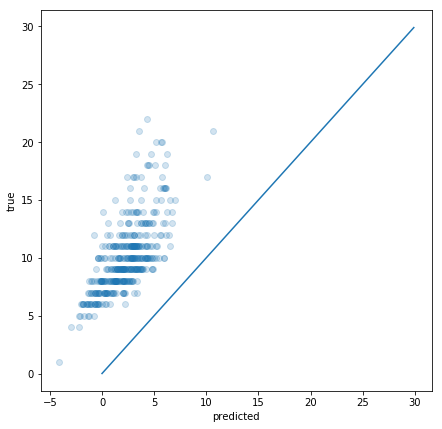

In [59]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)
ax.scatter(np.dot(X_test, model_lin_weights[0]), y_test, alpha=0.2)
ax.set_xlabel('predicted')
ax.set_ylabel('true')
ax.plot(np.arange(0, 30, 0.1), np.arange(0, 30, 0.1))

In [52]:
pred.values()

array([[ 3.04198990e+00],
       [ 3.43344237e+00],
       [ 3.85517891e+00],
       [ 3.64259779e+00],
       [ 2.79644766e+00],
       [ 1.67809673e+00],
       [ 1.45958306e+00],
       [ 4.89005500e+00],
       [ 2.97928874e+00],
       [ 1.01222730e+00],
       [ 2.98556528e+00],
       [ 4.35790398e+00],
       [ 2.11254464e+00],
       [ 4.97610335e+00],
       [ 4.96941271e+00],
       [ 1.87863979e+00],
       [ 5.44922052e+00],
       [-1.39500448e-01],
       [ 1.74340667e+00],
       [ 2.50827071e+00],
       [ 3.08678108e+00],
       [-1.33277311e+00],
       [ 1.43345143e+00],
       [ 1.16725514e+00],
       [-3.77100528e-01],
       [-4.76713798e-01],
       [ 1.26324215e+00],
       [ 5.54408473e+00],
       [ 5.66106937e+00],
       [-1.09470548e+00],
       [ 2.41179637e-01],
       [ 4.81773881e+00],
       [-2.75584523e-01],
       [ 8.14777798e-01],
       [ 3.36918884e+00],
       [ 3.91736691e+00],
       [ 2.61232934e+00],
       [-6.64390770e-01],
       [ 1.7

In [53]:
y_test.values

array([11, 12, 10,  9,  9,  8,  8, 13,  9, 11, 11, 18,  9, 12, 10,  9, 10,
        8, 10, 13, 12,  6,  9,  8, 10,  6, 11, 16, 12,  6,  7, 11,  7,  9,
        7,  9,  8,  7, 13, 11, 13,  8, 11, 11, 20,  8, 10,  6, 11,  8, 10,
        8,  8,  9, 10,  7, 11, 11, 15, 14, 10,  9, 17,  9, 11,  9, 14, 11,
        8, 11,  8,  9, 10,  7, 10,  9,  9,  7, 11,  8,  9,  7, 11,  7, 11,
       12, 13, 10,  7,  7,  6, 12,  8, 11, 13,  9, 11,  8, 11,  9, 10,  9,
       10,  6, 15,  8, 10, 16,  9,  9, 16,  9, 11,  9,  8,  7,  8, 11, 11,
        7, 17,  9,  8, 12,  9,  7, 12, 10, 10,  8, 11,  7,  8,  9,  9,  9,
        9,  7,  7, 10,  9,  7,  4, 12, 12, 10,  7, 10,  8, 10, 10,  8,  9,
        9,  8,  9, 10,  6, 11,  8,  9,  8,  9, 13, 18, 22, 13, 10, 15, 10,
       14,  8, 16, 10,  9, 13,  8,  7,  8, 10, 10, 10,  8, 15, 11,  6,  8,
       14,  8,  6,  7, 11,  4, 11,  8, 10,  9,  6, 13, 10, 11,  9, 10,  6,
       11, 13,  8,  9, 16, 11,  8,  8,  1,  8,  6,  9,  7,  6,  5, 10,  6,
        6,  7,  9, 13,  8